<a href="https://colab.research.google.com/github/Codeblockz/Data-Science-Self-Projects/blob/main/Kaggle_Titanic_challege/Titanic_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Challenge Kaggle <br></br>
[source 1](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)  <br></br>
[source 2]( https://www.kaggle.com/lonnieqin/classification-with-sklearn-and-tensorflow)

## Download Data

In [410]:
# from google.colab import files
# from os.path import exists
# file_exists = exists("/content/kaggle.json")
# if (file_exists==False):
#   files.upload()

In [411]:
%cd /content/drive/MyDrive/Colab Notebooks/Titanic

/content/drive/MyDrive/Colab Notebooks/Titanic


In [412]:
! pip install -q kaggle
!pip install --upgrade kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [413]:
 ! kaggle competitions download titanic

gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


Start To work on geting data

In [414]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import tensorflow as tf
from tensorflow import feature_column
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import string
import copy
from sklearn import preprocessing

In [415]:
# Load Data
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Titanic/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Titanic/test.csv")
train1 = copy.copy(train)
test1 = copy.copy(test)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Check For Nulls


In [416]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [417]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Check Data Types

In [418]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [419]:
test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

# Data Scrubing 

## Replace NaN

In [420]:
# from source 2
# Replace NAN
# embark_label = train["Embarked"].mode()[0]
# train["Cabin"] = train["Cabin"].replace(np.NAN,  "Unknown")
# train["Embarked"] = train["Embarked"].replace(np.NAN, embark_label)
# train["Age"] = train["Age"].replace(np.NAN, train["Age"].mean())

# # Test Replace
# test["Cabin"] = test["Cabin"].replace(np.NAN, "Unknown")
# test["Age"] = test["Age"].replace(np.NAN, test["Age"].mean())
# test["Fare"] = test["Fare"].replace(np.NAN, test["Fare"].mean())

In [421]:
def get_replaced_nan(data):
  embark_label = data["Embarked"].mode()[0]
  data["Cabin"] = data["Cabin"].replace(np.NAN,  "Unknown")
  data["Embarked"] = data["Embarked"].replace(np.NAN, embark_label)
  data["Age"] = data["Age"].replace(np.NAN, data["Age"].mean())
  data["Fare"] = data["Fare"].replace(np.NAN, data["Fare"].mean())
  return data

## Make Title Column

In [422]:
# source 1
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    # print(big_string) # For debug check
    return np.nan

In [423]:
#replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [424]:
# Apply function to data
# title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev', 'Dr', 'Ms', 'Mlle',
#             'Col', 'Capt', 'Mme', 'Countess', 'Don', 'Jonkheer']
# train['Title']=train['Name'].map(lambda x: substrings_in_string(x, title_list))
# test['Title'] = train['Name'].map(lambda x: substrings_in_string(x, title_list))
# train['Title']=train.apply(replace_titles, axis=1)
# test['Title']=test.apply(replace_titles, axis=1)

In [425]:
def get_titles(data):
  title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev', 'Dr', 'Ms', 'Mlle',
            'Col', 'Capt', 'Mme', 'Countess', 'Don', 'Jonkheer']
  data['Title']=data['Name'].map(lambda x: substrings_in_string(x, title_list))
  data['Title']=data.apply(replace_titles, axis=1)
  return data

In [426]:
# data check
#train.head()
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Make Cabin Type

In [427]:
# Make cabin type
# Source 2
# train['Cabin_type'] = train["Cabin"].apply(lambda cabin: cabin[0])
# test["Cabin_type"] = test["Cabin"].apply(lambda cabin: cabin[0])
# # Make New feature
# train["family_member_size"] = 1 + train["SibSp"] + train["Parch"]
# test["family_member_size"] = 1 + test["SibSp"] + test["Parch"]

In [428]:
# data check
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [429]:
# data check 
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Make Family Size Type

The correlation bellow shows that Family size is not linearly related however there is a relationship between survival and family size

In [430]:
def convert_faimly_member_size(size):
    if size == 1:
        return "single"
    elif size < 5:
        return "medium"
    else:
        return "large"

In [431]:
# should_add_family_member_type = True
# if should_add_family_member_type:
#     for data in [train, test]:
#         data["family_member_type"] = train["family_member_size"].apply(convert_faimly_member_size)

## Make Encoders

In [432]:
#encode_vals = ['Sex','Cabin_type','Embarked','Title','family_member_type']
VAL = ['Sex','Cabin_type','Embarked','Title','family_member_type']

In [433]:
# make non one hot encoded values
def make_encode_num(data):
  #val = ['Sex','Cabin_type','Embarked','Title','family_member_type']
  for feature in VAL:
    if feature in data.columns:
      data[feature]=data[feature].astype('category')
      data[feature+'_value']=np.int64(data[feature].cat.codes)
  return data
# train=make_encode_num(train)
# test = make_encode_num(test)

In [434]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [435]:
# make one hot encoding
# originally named one_hot_tit()
# I only relized after I made the function how bad the naming was
def one_hot(data, original_feature=False):
  for feature in VAL:
    if feature in data.columns:
      temp = data[feature]
      data= pd.get_dummies(data, columns=[feature], dtype=int)
      data.pop(feature+'_value')
      if original_feature == True :
        data[feature]=temp
  return data

## More Functions

### Get_Data

In [436]:
def get_data(data, should_add_family_member_type=False):
  # Replace NaNs
  data = get_replaced_nan(data)
  # get titles
  data = get_titles(data)
  # Get Cabin type
  data['Cabin_type'] = data["Cabin"].apply(lambda cabin: cabin[0])
  # Make New feature
  data["family_member_size"] = 1 + data["SibSp"] + data["Parch"]
  # Family memeber
  if should_add_family_member_type:
    data["family_member_type"] = data["family_member_size"].apply(convert_faimly_member_size)
  # encode
  data = make_encode_num(data)
  return data

### CleanUp

In [437]:
# make clean up
# Assumes all data in column is same type
# For numeric data
def cleanUp(data):
  for i in data.columns:
    #print(data[i])
    if isinstance(data[i].iloc[0],(np.float, np.integer))==False:
      # print(i)
      data.pop(i)
  data.pop("PassengerId")
  return data 

### getTuple

In [438]:
# number reshape
def getTuple(Value):
  x, y = Value.shape
  z=1
  t = (x,y,z)
  return t 

### get_train_test

In [439]:
def get_train_test(data, CC):
  X = data.drop("Survived", axis=1)
  y = data["Survived"]
  #print("X shape: ", X.shape)
  #print(X.values.reshape(891, 27,1))
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
  if CC==True:
    X_train=X_train.values
    y_train= y_train.values
    X_val= X_val.values
    y_val=y_val.values
    X_train=np.expand_dims(X_train,axis=2)
    X_val=np.expand_dims(X_val,axis=2)
  return (X_train, X_val, y_train, y_val)

### make_tensor

In [440]:
def make_tensor(data):
  X_train, X_val, y_train, y_val = get_train_test(data)
  print("X_train shape: ", X_train.shape)
  print("X_train Type: ", type(X_train))
  print("y_train: ",y_train.shape)
  train_tensor = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
  val_tensor = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
  return train_tensor, val_tensor

In [441]:
# # Testing
# ##################################
# X = copy.copy(OH_train)
# X = X.drop("Survived", axis=1)
# #print("X shape: ", X.shape)
# xshap = X.shape
# x, y = X.shape
# t = (x,y,1)
# #print(t)
# OH_tt, OH_tv = make_tensor(OH_train)
# OH_tt.element_spec

## Apply Functions

### Manual Data Scrub and Format

In [442]:
embark_label = train["Embarked"].mode()[0]
train["Cabin"] = train["Cabin"].replace(np.NAN,  "Unknown")
train["Embarked"] = train["Embarked"].replace(np.NAN, embark_label)
train["Age"] = train["Age"].replace(np.NAN, train["Age"].mean())
# Test Replace
test["Cabin"] = test["Cabin"].replace(np.NAN, "Unknown")
test["Age"] = test["Age"].replace(np.NAN, test["Age"].mean())
test["Fare"] = test["Fare"].replace(np.NAN, test["Fare"].mean())
# Make Titles
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev', 'Dr', 'Ms', 'Mlle',
            'Col', 'Capt', 'Mme', 'Countess', 'Don', 'Jonkheer']
train['Title']=train['Name'].map(lambda x: substrings_in_string(x, title_list))
test['Title'] = train['Name'].map(lambda x: substrings_in_string(x, title_list))
train['Title']=train.apply(replace_titles, axis=1)
test['Title']=test.apply(replace_titles, axis=1)
# Make Cabin Type
train['Cabin_type'] = train["Cabin"].apply(lambda cabin: cabin[0])
test["Cabin_type"] = test["Cabin"].apply(lambda cabin: cabin[0])
# Family Size
train["family_member_size"] = 1 + train["SibSp"] + train["Parch"]
test["family_member_size"] = 1 + test["SibSp"] + test["Parch"]
# family size type
should_add_family_member_type = True
if should_add_family_member_type:
    for data in [train, test]:
        data["family_member_type"] = train["family_member_size"].apply(convert_faimly_member_size)
# regular encode
train = make_encode_num(train)
test = make_encode_num(test)

### Express Data Scrub and Format

In [443]:
# For Simplicity
train_test = pd.concat([train1,test1])
train_test = get_data(train_test, True)
train = train_test.iloc[0:len(train)]
test = train_test.iloc[len(train):]

### One Hot encode Data
- Prepare data for models <br>
- OH stands for one hot <br>
- EN stands for encoded, not one hot<br>
- Use concat to save time

In [444]:
OH_train_test = pd.concat([train,test])
EN_train_test = pd.concat([train, test])
# print shape and size for latter
print("Train Shape: ",train.shape)
print("Train Size: ", len(train))

Train Shape:  (891, 21)
Train Size:  891


In [445]:
# apply OH
# remember to apply with and without family type and size
OH_train_test=one_hot(OH_train_test, False)
OH_train_test = cleanUp(OH_train_test)
OH_train_test["Survived"] = OH_train_test["Survived"].replace(np.NAN, np.int(1))
# Apply EN
EN_train_test = cleanUp(EN_train_test)
EN_train_test["Survived"] = EN_train_test["Survived"].replace(np.NAN, np.int(1))

In [446]:
# Testing
##########################################
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width',None)
# pd.set_option('display.max_colwidth', -1)
# pd.reset_option("^display")
# OH_train_test#

### Normalization 

In [447]:
# Scaling
min_max_scaler = preprocessing.MinMaxScaler()
OH_scaled = min_max_scaler.fit_transform(OH_train_test)
EN_scaled = min_max_scaler.fit_transform(EN_train_test)
OH_train_test = pd.DataFrame(OH_scaled, columns=OH_train_test.columns)
EN_train_test = pd.DataFrame(EN_scaled, columns=EN_train_test.columns)

In [448]:
# train and test
EN_train = EN_train_test.iloc[0:len(train)]
OH_train = OH_train_test.iloc[0:len(train)]
EN_test = EN_train_test.iloc[len(train):]
OH_test = OH_train_test.iloc[len(train):]
EN_test = EN_test.drop("Survived", axis=1)
OH_test = OH_test.drop("Survived", axis=1)

In [449]:
# data check
OH_train_test.head()
# OH_train.shape
# OH_tt.element_spec
EN_test

,Pclass,Age,SibSp,Parch,Fare,family_member_size,Sex_value,Cabin_type_value,Embarked_value,Title_value,family_member_type_value
891,1.0,0.430039,0.000,0.000000,0.015282,0.0,1.0,1.00,0.5,0.666667,1.0
892,1.0,0.586622,0.125,0.000000,0.013663,0.1,0.0,1.00,1.0,1.000000,0.5
893,0.5,0.774521,0.000,0.000000,0.018909,0.0,1.0,1.00,0.5,0.666667,1.0
894,1.0,0.336089,0.000,0.000000,0.016908,0.0,1.0,1.00,1.0,0.666667,1.0
895,1.0,0.273456,0.125,0.111111,0.023984,0.2,0.0,1.00,1.0,1.000000,0.5
...,...,...,...,...,...,...,...,...,...,...,...
1304,1.0,0.372180,0.000,0.000000,0.015713,0.0,1.0,1.00,1.0,0.666667,1.0
1305,0.0,0.486409,0.000,0.000000,0.212559,0.0,0.0,0.25,0.0,0.666667,1.0
1306,1.0,0.480145,0.000,0.000000,0.014151,0.0,1.0,1.00,1.0,0.666667,1.0
1307,1.0,0.372180,0.000,0.000000,0.015713,0.0,1.0,1.00,1.0,0.666667,1.0


In [450]:
# data check
test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_type,family_member_size,family_member_type,Sex_value,Cabin_type_value,Embarked_value,Title_value,family_member_type_value
0,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Unknown,Q,Mr,U,1,single,1,8,1,2,2
1,893,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Unknown,S,Mrs,U,2,medium,0,8,2,3,1
2,894,NaN,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Unknown,Q,Mr,U,1,single,1,8,1,2,2
3,895,NaN,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Unknown,S,Mr,U,1,single,1,8,2,2,2
4,896,NaN,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Unknown,S,Mrs,U,3,medium,0,8,2,3,1


In [451]:
#temp.corr()["Survived"].sort_values(key=lambda x: abs(x), ascending=False)

# Exploratory Data Analysis For Survival

In [452]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   PassengerId               891 non-null    int64   
 1   Survived                  891 non-null    float64 
 2   Pclass                    891 non-null    int64   
 3   Name                      891 non-null    object  
 4   Sex                       891 non-null    category
 5   Age                       891 non-null    float64 
 6   SibSp                     891 non-null    int64   
 7   Parch                     891 non-null    int64   
 8   Ticket                    891 non-null    object  
 9   Fare                      891 non-null    float64 
 10  Cabin                     891 non-null    object  
 11  Embarked                  891 non-null    category
 12  Title                     891 non-null    category
 13  Cabin_type                891 non-null    category

In [453]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,family_member_size,Sex_value,Cabin_type_value,Embarked_value,Title_value,family_member_type_value
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.735277,0.523008,0.381594,32.204208,1.904602,0.647587,6.716049,1.536476,1.860831,1.533109
std,257.353842,0.486592,0.836071,13.002218,1.102743,0.806057,49.693429,1.613459,0.477990,2.460739,0.791503,0.721066,0.623305
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,1.000000,0.000000,8.000000,1.000000,2.000000,1.000000
50%,446.000000,0.000000,3.000000,29.881138,0.000000,0.000000,14.454200,1.000000,1.000000,8.000000,2.000000,2.000000,2.000000
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,2.000000,1.000000,8.000000,2.000000,2.000000,2.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,11.000000,1.000000,8.000000,2.000000,3.000000,2.000000


## Survival by Cabin Type

In [454]:
train.groupby("Cabin_type")["Survived"].mean()

Cabin_type
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
U    0.299854
Name: Survived, dtype: float64

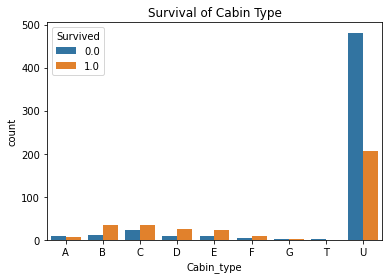

In [455]:
sns.countplot(x="Cabin_type",hue="Survived", data=train)
plt.title("Survival of Cabin Type")
plt.show()

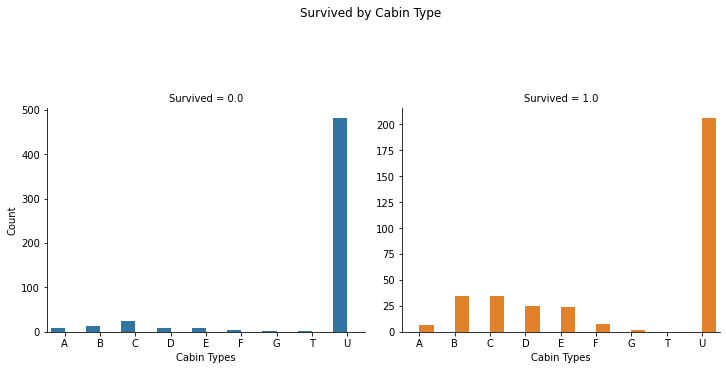

In [456]:
cabin_type_plot= sns.catplot(x="Cabin_type", hue="Survived", col="Survived", data=train, kind="count", sharey=False)
cabin_type_plot.fig.subplots_adjust(top=0.7)
cabin_type_plot.fig.suptitle("Survived by Cabin Type")
cabin_type_plot.set_xlabels("Cabin Types")
cabin_type_plot.set_ylabels("Count")
plt.show()

## Survival by Pclass

In [457]:
train.groupby("Pclass")["Survived"].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

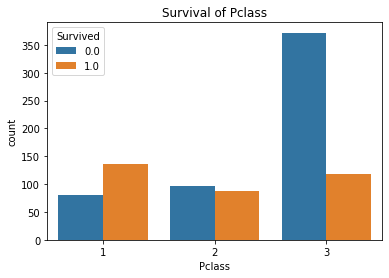

In [458]:
sns.countplot(x="Pclass",hue="Survived", data=train)
plt.title("Survival of Pclass")
plt.show()

## Survival by Sex

In [459]:
train.groupby("Pclass")["Survived"].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

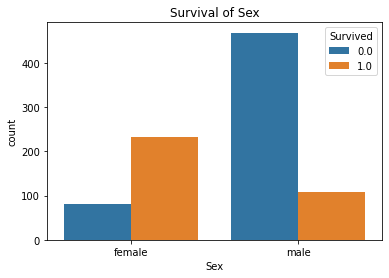

In [460]:
sns.countplot(x="Sex",hue="Survived", data=train)
plt.title("Survival of Sex")
plt.show()

## Survival by Age

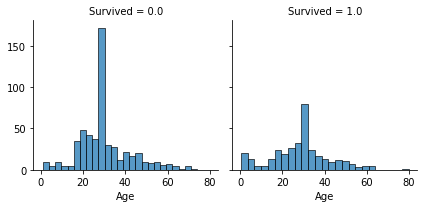

In [461]:
sns.FacetGrid(train, col="Survived").map(sns.histplot, "Age", bins=25)
plt.show()

## Survial by Sibsp

In [462]:
train.groupby("SibSp")["Survived"].mean()

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

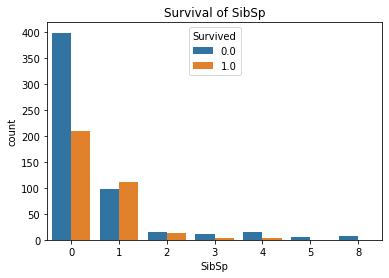

In [463]:
sns.countplot(x="SibSp",hue="Survived", data=train)
plt.title("Survival of SibSp")
plt.show()

## Survival by Parch

In [464]:
train.groupby("Parch")["Survived"].mean()

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

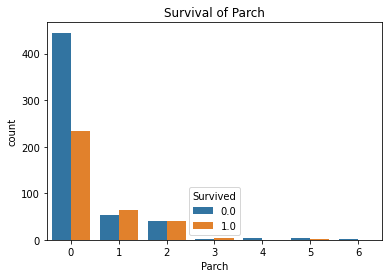

In [465]:
sns.countplot(x="Parch",hue="Survived", data=train)
plt.title("Survival of Parch")
plt.show()


## Survival by Fare


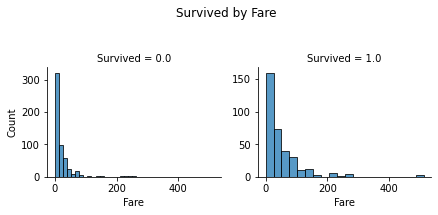

In [466]:
Fare_plot=sns.FacetGrid(train, col="Survived", sharey=False)
Fare_plot.map(sns.histplot, "Fare",bins=20)
Fare_plot.fig.subplots_adjust(top=0.7)
Fare_plot.fig.suptitle("Survived by Fare")
Fare_plot.set_xlabels("Fare")
Fare_plot.set_ylabels("Count")
plt.show()

## Survival by Embarked


In [467]:
train.groupby("Embarked")["Survived"].mean()

Embarked
C    0.553571
Q    0.389610
S    0.339009
Name: Survived, dtype: float64

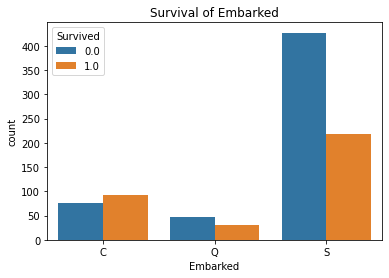

In [468]:
sns.countplot(x="Embarked",hue="Survived",data=train)
plt.title("Survival of Embarked")
plt.show()

## Survived by Title

In [469]:
train.groupby("Title")["Survived"].mean()

Title
Master    0.575000
Miss      0.703297
Mr        0.158192
Mrs       0.775362
Name: Survived, dtype: float64

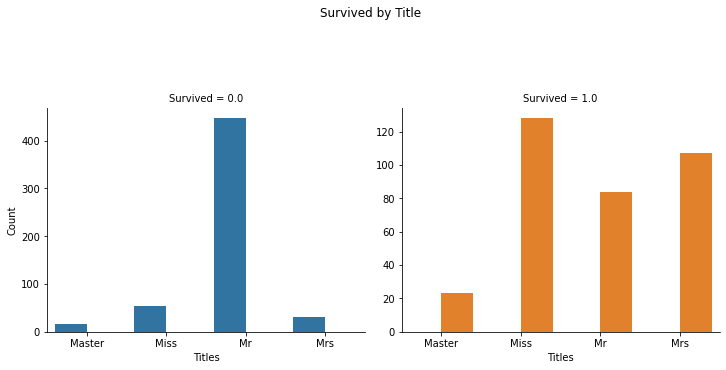

In [470]:
title_plot= sns.catplot(x="Title", hue="Survived", col="Survived", data=train, kind="count", sharey=False)
title_plot.fig.subplots_adjust(top=0.7)
title_plot.fig.suptitle("Survived by Title")
title_plot.set_xlabels("Titles")
title_plot.set_ylabels("Count")
plt.show()

In [471]:
train.max()

PassengerId                                         891
Survived                                              1
Pclass                                                3
Name                        van Melkebeke, Mr. Philemon
Age                                                  80
SibSp                                                 8
Parch                                                 6
Ticket                                        WE/P 5735
Fare                                            512.329
Cabin                                           Unknown
family_member_size                                   11
Sex_value                                             1
Cabin_type_value                                      8
Embarked_value                                        2
Title_value                                           3
family_member_type_value                              2
dtype: object

## Survival Factors

In [472]:
# source 2
train.corr()["Survived"].sort_values(key=lambda x: abs(x), ascending=False)

Survived                    1.000000
Sex_value                  -0.543351
Pclass                     -0.338481
Cabin_type_value           -0.301116
Fare                        0.257307
Embarked_value             -0.167675
family_member_type_value   -0.108631
Parch                       0.081629
Age                        -0.070323
Title_value                -0.062139
SibSp                      -0.035322
family_member_size          0.016639
PassengerId                -0.005007
Name: Survived, dtype: float64

In [473]:
# See what .index Does
# index gives the feature values that equaled true
###########################################################
# l=list(train.corr()[train.corr()["Survived"].abs()>.05] )
# p=list(train.corr()[train.corr()["Survived"].abs()>.05].index )
# print(len(l),"\n",l)
# print(len(p),"\n",p)
# res = [x for x in l + p if x not in l or x not in p]
# print(res)

In [474]:
# Source 2
related_columns = list(train.corr()[train.corr()["Survived"].abs() > 0.05].index)
related_columns.remove("Survived")
print(related_columns)

['Pclass', 'Age', 'Parch', 'Fare', 'Sex_value', 'Cabin_type_value', 'Embarked_value', 'Title_value', 'family_member_type_value']


# Models

In [475]:
Models = dict()
Model_acc = dict()

In [476]:
# Models['OH_CNN_model']=[OH_CNN_model,OH_acc_CNN[1]]
# Models['EN_CNN_model']=[EN_CNN_model, EN_acc_CNN[1]]

## DNN Models

### CNN Model

In [477]:
## testing
# X_train, X_val, y_train, y_val = get_train_test(OH_train, True)
# # X_train=X_train.values
# # y_train= y_train.values
# # X_val= X_val.values
# # y_val=y_val.values
# # X_train=np.expand_dims(X_train,axis=2)
# # X_val=np.expand_dims(X_val,axis=2)
# X_train, X_val, y_train, y_val = get_train_test(EN_train, True)
# print("X_val.shape: ",X_val.shape)
# print("y_val.shape: ",y_val.shape)
# print("X_train.shape: ",X_train.shape)
# print("y_train.shape: ",y_train.shape)

In [478]:
def makeCN_Model(input_shape):
  model = tf.keras.Sequential([
  #tf.keras.layers.Input(27,1),
  tf.keras.layers.Conv1D(128, 2, activation='relu',input_shape=input_shape),
  tf.keras.layers.MaxPooling1D(pool_size=2),
  tf.keras.layers.Conv1D(128, 4, activation='relu'),
  tf.keras.layers.MaxPooling1D(pool_size=2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(50, activation="relu"),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model
#model.summary()

In [479]:
# for OH
X_train, X_val, y_train, y_val = get_train_test(OH_train, True)
x, y, z = X_train.shape
print("X_val.shape: ",X_val.shape)
print("y_val.shape: ",y_val.shape)
print("X_train.shape: ",X_train.shape)
print("y_train.shape: ",y_train.shape)
input_shape = (y,z)
OH_CNN_model=makeCN_Model((y,z))
# OH_CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
OH_CNN_model.summary()

X_val.shape:  (179, 27, 1)
y_val.shape:  (179,)
X_train.shape:  (712, 27, 1)
y_train.shape:  (712,)
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 26, 128)           384       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 13, 128)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 10, 128)           65664     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 5, 128)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 100)               64100     
___________________

Accuracy:  0.8156424760818481


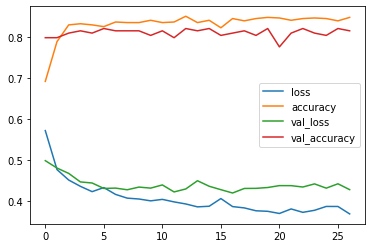

In [480]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=10)
history = OH_CNN_model.fit(
    X_train, y_train,epochs=400, 
    validation_data=(X_val,y_val), 
    callbacks=[early_stop],
    verbose=0
)
pd.DataFrame(history.history).plot()
acc_ofmodel = OH_CNN_model.evaluate(X_val, y_val, verbose=0)
print("Accuracy: ",acc_ofmodel[1])

In [481]:
OH_acc_CNN = OH_CNN_model.evaluate(X_val, y_val, verbose=0)
print("Accuracy: ",OH_acc_CNN[1])
Models['OH_CNN_model']=[OH_CNN_model,OH_acc_CNN[1]]

Accuracy:  0.8156424760818481


In [482]:
# For EN
X_train, X_val, y_train, y_val = get_train_test(EN_train, True)
x, y, z = X_train.shape
print("X_val.shape: ",X_val.shape)
print("y_val.shape: ",y_val.shape)
print("X_train.shape: ",X_train.shape)
print("y_train.shape: ",y_train.shape)
input_shape = (y,z)
# print(input_shape)
EN_CNN_model=makeCN_Model((y,z))
# EN_CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
EN_CNN_model.summary()

X_val.shape:  (179, 11, 1)
y_val.shape:  (179,)
X_train.shape:  (712, 11, 1)
y_train.shape:  (712,)
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 10, 128)           384       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 5, 128)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 2, 128)            65664     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 100)               12900     
___________________

Accuracy:  0.8100558519363403


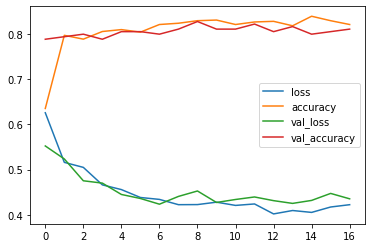

In [483]:
history = EN_CNN_model.fit(
    X_train, y_train,epochs=4000, 
    validation_data=(X_val,y_val), 
    callbacks=[early_stop],
    verbose=0
)
pd.DataFrame(history.history).plot()
acc_ofmodel = EN_CNN_model.evaluate(X_val, y_val, verbose=0)
print("Accuracy: ",acc_ofmodel[1])

In [484]:
# For Comparison 
EN_acc_CNN = EN_CNN_model.evaluate(X_val, y_val, verbose=0)
Models['EN_CNN_model']=[EN_CNN_model, EN_acc_CNN[1]]

### DNN Model

In [485]:
def fit_DNN_Model(model, epochs=400):
  history = model.fit(
    X_train, y_train,epochs=epochs, 
    validation_data=(X_val,y_val), 
    callbacks=[early_stop],
    verbose=0
  )
  pd.DataFrame(history.history).plot()
  acc_ofmodel = model.evaluate(X_val, y_val, verbose=0)
  print("Accuracy: ",acc_ofmodel[1])
  return acc_ofmodel[1]

In [486]:
def DNN_model(input_dim):
   model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(input_dim)),
      tf.keras.layers.Dense(1000, activation='relu'), 
      tf.keras.layers.Dense(750, activation='relu'),  
      tf.keras.layers.Dense(500, activation='relu'),  
      tf.keras.layers.Dense(250, activation='relu'),  
      tf.keras.layers.Dense(50, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')                          
   ])
   model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
   return model

Accuracy:  0.8156424760818481


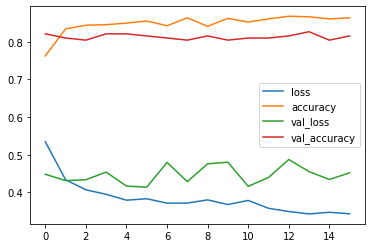

In [487]:
X_train, X_val, y_train, y_val = get_train_test(OH_train, False)
OH_DNN_model = DNN_model(X_train.shape[1])
OH_acc_DNN = fit_DNN_Model(OH_DNN_model)
Models['OH_DNN_model']=[OH_DNN_model,OH_acc_DNN]

Accuracy:  0.8212290406227112


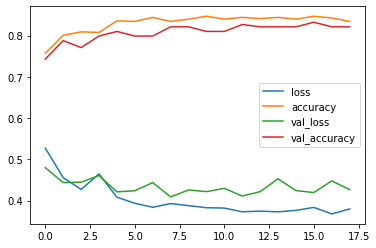

In [488]:
X_train, X_val, y_train, y_val = get_train_test(EN_train, False)
EN_DNN_model = DNN_model(X_train.shape[1])
EN_acc_DNN = fit_DNN_Model(EN_DNN_model)
Models['EN_DNN_model']=[EN_DNN_model,EN_acc_DNN]

### Deep and Wide Model

In [489]:
categorical_feature_names = ["Pclass", "Sex_value", "Embarked_value", "Cabin_type_value"]
numerical_feature_names = ["Age", "Fare", "SibSp", "Parch", "family_member_size"]
categorical_features = [
    feature_column.indicator_column(
        feature_column.categorical_column_with_vocabulary_list(key, sorted(list(train[key].unique())))
    ) for key in categorical_feature_names
]
print(categorical_features)
numerical_features = [feature_column.numeric_column(key) for key in numerical_feature_names]
input_dictionary = dict()
inputs = dict()
for item in numerical_features:
    inputs[item.key] = tf.keras.layers.Input(name=item.key, shape=())
for item in categorical_features:
    #print(item.categorical_column.key)
    inputs[item.categorical_column.key] = tf.keras.layers.Input(name=item.categorical_column.key, shape=(), dtype="int32")

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Pclass', vocabulary_list=(1, 2, 3), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Sex_value', vocabulary_list=(0, 1), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Embarked_value', vocabulary_list=(0, 1, 2), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Cabin_type_value', vocabulary_list=(0, 1, 2, 3, 4, 5, 6, 7, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0))]


In [490]:
# Source 2 
# Helper Features
def features_and_labels(row_data):
    label = row_data.pop("Survived")
    features = row_data
    # print("Label: ", label)
    # print("Feature: ", features)
    return features, label

def create_dataset(pattern, epochs=1, batch_size=32, mode='eval'):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size
    )
    # print("Before map: ", dataset)
    dataset = dataset.map(features_and_labels)
    # print("After map: ",dataset)
    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=128).repeat(epochs)
    #print(dataset)
    dataset = dataset.prefetch(1)
    #print("after prefetch\n",dataset)
    return dataset

def create_test_dataset(pattern, batch_size=32):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size
    )
    dataset = dataset.map(lambda features: features)
    dataset = dataset.prefetch(1)
    return dataset

In [491]:
# Train test split
train_data, val_data = train_test_split(
    train[categorical_feature_names + numerical_feature_names + ["Survived"]],
    test_size=.2,
    random_state=np.random.randint(0, 1000)
)
train_data.to_csv("train_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)
test[categorical_feature_names + numerical_feature_names].to_csv("test_data.csv", index=False)
batch_size = 32
train_dataset = create_dataset("train_data.csv", batch_size=batch_size, mode='train')
val_dataset = create_dataset("val_data.csv", batch_size=val_data.shape[0], mode='eval').take(1)
test_dataset = create_test_dataset("test_data.csv", batch_size = test.shape[0]).take(1)

In [492]:
# D&W Model
def build_deep_and_wide_model():
    deep = tf.keras.layers.DenseFeatures(numerical_features, name='deep')(inputs)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    wide = tf.keras.layers.DenseFeatures(categorical_features, name='wide')(inputs)
    wide = tf.keras.layers.Dense(32, activation='relu')(wide)
    combined = tf.keras.layers.concatenate(inputs=[deep, wide], name='combined')
    output = tf.keras.layers.Dense(1, activation="sigmoid")(combined)
    model = tf.keras.Model(inputs=list(inputs.values()), outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

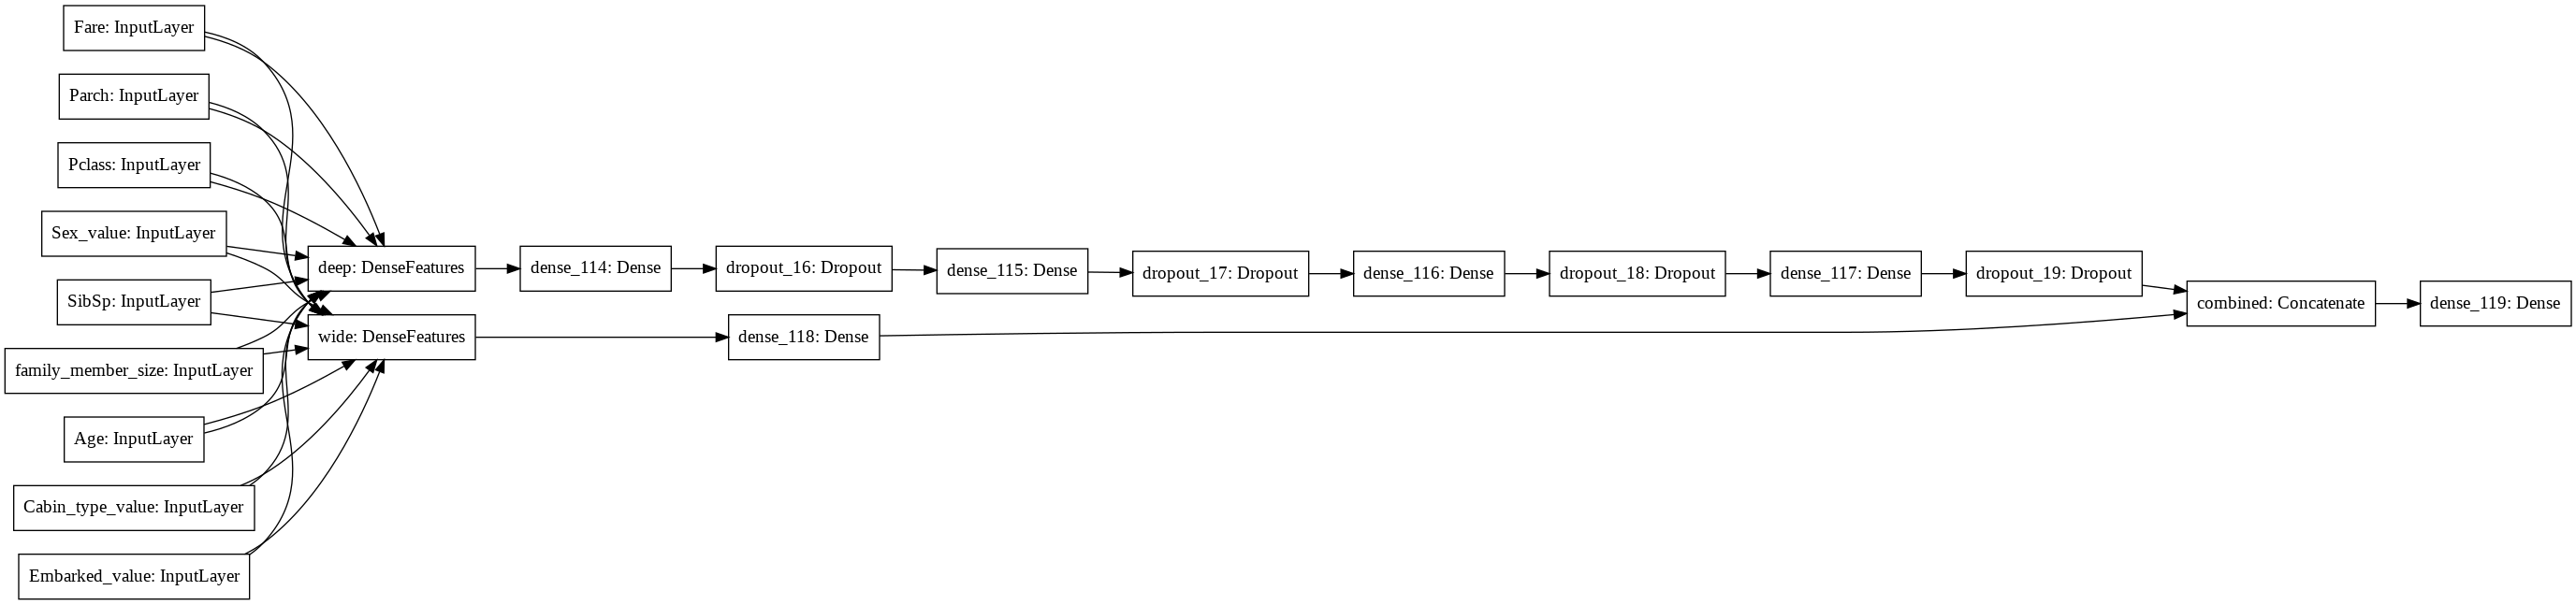

In [493]:
deep_and_wide_model = build_deep_and_wide_model()
tf.keras.utils.plot_model(deep_and_wide_model, show_shapes=False, rankdir='LR')

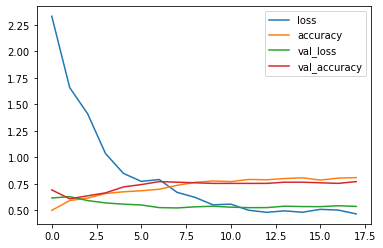

In [494]:
epochs = 400
early_stop = tf.keras.callbacks.EarlyStopping(patience=10)
steps_per_epoch = train_data.shape[0] // batch_size
history = deep_and_wide_model.fit(
    train_dataset, 
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=0
)
pd.DataFrame(history.history).plot()

In [495]:
# y_pred =  np.array(deep_and_wide_model.predict(val_dataset) > 0.5, dtype=int).reshape(-1)
y_pred = np.array(deep_and_wide_model.predict(val_dataset)>0.5,dtype=int).reshape(-1)
score = accuracy_score(val_data["Survived"], y_pred)
print("Accuraccy Score: ",score)
print(sklearn.metrics.classification_report(val_data["Survived"], y_pred))
Survived = np.argmax(deep_and_wide_model.predict(test_dataset), axis=-1).reshape(-1)
# print(np.argmax(deep_and_wide_model.predict(test_dataset),axis=1).reshape(-1))
# print(test.shape)
print(Survived.shape)
Models['deep_and_wide_model']=[deep_and_wide_model,score]

Accuraccy Score:  0.48044692737430167
              precision    recall  f1-score   support

         0.0       0.50      0.63      0.56        92
         1.0       0.45      0.32      0.38        87

    accuracy                           0.48       179
   macro avg       0.47      0.48      0.47       179
weighted avg       0.47      0.48      0.47       179

(418,)


## Other Models

### Logistic Regression

In [496]:
EN_train.corr()["Survived"].sort_values(key=lambda x: abs(x), ascending=False)

Survived                    1.000000
Sex_value                  -0.543351
Pclass                     -0.338481
Cabin_type_value           -0.301116
Fare                        0.257307
Embarked_value             -0.167675
family_member_type_value   -0.108631
Parch                       0.081629
Age                        -0.070323
Title_value                -0.062139
SibSp                      -0.035322
family_member_size          0.016639
Name: Survived, dtype: float64

In [497]:
LT = list(EN_train.corr()[EN_train.corr()["Survived"].abs() > 0.2].index) 
LT1 = list(OH_train.corr()[OH_train.corr()["Survived"].abs() > 0.2].index) 
L_dataset1 = EN_train[LT]
L_dataset2 = OH_train[LT1]
L_dataset3 = copy.copy(OH_train)
L_dataset4 = copy.copy(EN_train)
L_datasets = [L_dataset1, L_dataset2, L_dataset3, L_dataset4]

In [498]:
from sklearn.linear_model import LogisticRegression
best_logit = None
best_solver = ""
best_logit_score = 0
count =0
for data in L_datasets:
  X_train, X_val, y_train, y_val = get_train_test(data, False)
  for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
      logit = LogisticRegression(solver=solver)
      logit.fit(X_train, y_train)
      score = logit.score(X_val, y_val)
      if score > best_logit_score:
          best_solver = solver
          best_logit_score = score
          best_logit = logit
          #print(count)
  #count+=1
print("Best Solver:", best_solver, "Score:", best_logit_score)
Models['logit'] = [best_logit, best_logit_score]

Best Solver: newton-cg Score: 0.8268156424581006


### Stochastic Gradient Descent

In [499]:
# import numpy as np
# from sklearn.linear_model import SGDClassifier
# import time
# best_sgd_score = 0
# best_depth = 5
# best_n_estimators = 5
# best_learning_rate = 'adaptive'
# best_sgd_model = None
# sgd_stats = {'best_sgd_score': 0,
#     'best_learning_rate': 'adaptive',
#     'best_sgd_model' : None,
#     'best_loss' : 'hinge',
#     'best_max_iter' : 1000,
#     'best_et0':0.0,
#     'cur_et0': 0.0,
#     'cur_learning_rate': 'adaptive',
#     'cur_loss' : 'hinge',
#     'cur_max_iter' : 1000,
#     }
# # loss
# # max_iter
# SGD_datasets = L_datasets
# X_train, X_val, y_train, y_val = get_train_test(OH_train, False)
# rates = ['adaptive', 'optimal', 'constant', 'invscaling']

# ## catch All Function
# def best_lr_sgd(model, tv, stats = sgd_stats):
#   model.fit(tv['X_train'], tv['y_train'])
#   score = model.score(tv['X_val'], tv['y_val'])
#   if score > stats['best_sgd_score']:
#         stats['best_learning_rate'] = stats['cur_learning_rate']
#         stats['best_loss'] = stats['cur_loss']
#         stats['best_et0'] = stats['cur_et0']
#         stats['best_max_iter'] = model.n_iter
#         stats['best_sgd_score'] = score
#         stats['best_sgd_model'] = model
#   return stats
# start_time = time.time()
# for data in SGD_datasets:
#   X_train, X_val, y_train, y_val = get_train_test(data, False)
#   sgd_tv =  {'X_train':X_train, 'X_val':X_val, 'y_train':y_train, 'y_val':y_val}
#   for eta in list(np.arange(0.001, 0.15, 0.001)):
#   # Learning Rate
#     for rate in rates:
#       for mit in list(np.arange(1000.0,10000.0,10.0)):
#         sgd = SGDClassifier(
#                 loss= sgd_stats['best_loss'],
#                 max_iter = mit,
#                 learning_rate = rate, 
#                 eta0 = eta,
#                 random_state= 42, #np.random.randint(1, 1000)
#                 early_stopping =True
#               )
#         sgd_stats['cur_learning_rate'] = rate
#         sgd_stats['cur_et0'] = eta
#         sgd_stats['cur_loss'] = sgd_stats['best_loss']
#         sgd_stats['cur_max_iter'] = mit
#         sgd_stats = best_lr_sgd(sgd,sgd_tv)
# duration = time.time() - start_time 
# print("Best Learning Rate:", sgd_stats['best_learning_rate'], "\nBest iter: ", sgd_stats['best_max_iter'], "\nBest Score (best mean acc): ", sgd_stats['best_sgd_score'])

# # for learning_rate in list(np.arange(0.05, 0.15, 0.01)):
# #     sgd = SGDClassifier(
# #             n_estimators=best_n_estimators, 
# #             learning_rate=learning_rate, 
# #             max_depth=best_depth, 
# #             random_state=np.random.randint(1, 1000)
# #     )
# #     sgd.fit(train_features, train_targets)
# #     score = sgd.score(validation_features, validation_targets)
# #     if score > best_sgd_score:
# #         best_learning_rate = learning_rate
# #         best_sgd_score = score
# #         best_sgd_model = sgd
# # print("Best Learning Rate:", best_learning_rate)


In [500]:
import numpy as np
from sklearn.linear_model import SGDClassifier
import time
from sklearn.model_selection import RandomizedSearchCV
best_sgd_score = 0
best_depth = 5
best_n_estimators = 5
best_learning_rate = 'adaptive'
best_sgd_model = None
sgd_stats = {'best_sgd_score': 0,
    'best_learning_rate': 'adaptive',
    'best_sgd_model' : None,
    'best_loss' : 'hinge',
    'best_max_iter' : 1000,
    'best_et0':0.0,
    'cur_et0': 0.0,
    'cur_learning_rate': 'adaptive',
    'cur_loss' : 'hinge',
    'cur_max_iter' : 1000,
    }
# loss
# max_iter
# SGD_datasets = L_datasets
X_train, X_val, y_train, y_val = get_train_test(OH_train, False)
learning_rate = ['adaptive', 'optimal', 'constant', 'invscaling']
eta0 = list(np.arange(0.001, 0.15, 0.001))
max_iter = list(np.arange(1000.0,10000.0,10.0))
random_state= [42]
early_stopping =[True]
loss = ['hinge','log','modified_huber','squared_hinge','perceptron' ]
X_train = OH_train.drop("Survived", axis=1)
y_train = OH_train['Survived']

param_distributions = dict(loss=loss, 
                           max_iter = max_iter, 
                           learning_rate = learning_rate, 
                           eta0 = eta0,
                           early_stopping=early_stopping
                           )
sgd = SGDClassifier()
random = RandomizedSearchCV(sgd, param_distributions,
                            n_iter=10000, scoring='accuracy', n_jobs=-1, 
                            cv=3, verbose=3, random_state=42)
stuff = random.fit(X_train, y_train)
print("Best Score: ", stuff.best_score_)

Fitting 3 folds for each of 10000 candidates, totalling 30000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 840 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 2120 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 3912 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 6216 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 9032 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 12360 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 16200 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 20552 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 25416 tasks      | elapsed:  4.2min


Best Score:  0.8372615039281707


[Parallel(n_jobs=-1)]: Done 30000 out of 30000 | elapsed:  4.9min finished


### Dict set up

In [530]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import RationalQuadratic

# Models
sgd = SGDClassifier(random_state = 42)
lr = LogisticRegression(random_state = 42)
svm = SVC(random_state = 42)
knn = KNeighborsClassifier()
gpc = GaussianProcessClassifier(random_state = 42)
dtc = DecisionTreeClassifier(random_state = 42)
abc = AdaBoostClassifier(random_state = 42)
rfc = RandomForestClassifier(random_state = 42)
gbc = GradientBoostingClassifier(random_state = 42)
# Model Dict
models = dict(sgd = sgd, 
              lr = lr, 
              svm = svm, 
              knn= knn, 
              gpc = gpc, 
              dtc = dtc, 
              abc =abc, 
              rfc = rfc,
              gbc = gbc)
# Parameters
params = {
    
    'sgd':dict(learning_rate = ['adaptive', 'optimal', 'constant', 'invscaling'],
               eta0 = list(np.arange(0.001, 0.15, 0.001)),
               max_iter = list(np.arange(1000.0,10000.0,10.0)),
               random_state= [42],
               early_stopping =[True]),
    'lr':dict(solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              C = list(np.arange(1,20)),
              max_iter = list(np.arange(100,1000,10))
              ),
    'svm':dict(gamma = ['scale', 'auto'],
               max_iter = [-1]),
    'knn':dict(n_neighbors = list(np.arange(5,50,5)),
               algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute'],
               leaf_size = list(np.arange(30,100, 10))
               ),
    'gpc':dict(max_iter_predict = list(np.arange(100,1000,10))
               ),
    'dtc':dict(criterion = ['gini', 'entropy'],
               max_depth = [None]+list(np.arange(10,100,10)),
               min_samples_split = list(np.arange(2,10,2)),
               min_samples_leaf =  list(np.arange(1,10)),
               max_features = ['auto', 'sqrt', 'log2'] ,
               max_leaf_nodes = [None]+list(np.arange(100,1000,10))       
               ),
    'abc':dict(n_estimators = list(np.arange(50,100,10)),
              learning_rate = list(np.arange(1,20,1)),
              algorithm = ['SAMME', 'SAMME.R']             
               ),
    'rfc':dict(n_estimators = list(np.arange(100,500,10)),
              criterion = ['gini', 'entropy'],
              max_depth = [None]+list(np.arange(10,100,10)),
              min_samples_split = list(np.arange(2,10,2)),
              min_samples_leaf =  list(np.arange(1,10)),
              max_features = ['auto', 'sqrt', 'log2'] ,
              max_leaf_nodes = [None]+list(np.arange(100,1000,10))        
               ),
    'gbc':dict(loss=['deviance', 'exponential'],
               learning_rate = list(np.arange(0.05,0.5,0.05, dtype = float)),
               n_estimators = list(np.arange(100,500,10)),
               criterion=['friedman_mse', 'mse', 'mae'],
               min_samples_split = list(np.arange(2,10,2)),
               min_samples_leaf =  list(np.arange(1,10)),
               max_depth = list(np.arange(3,50,1)),
               max_features = ['auto', 'sqrt', 'log2'],
               max_leaf_nodes = [None]+list(np.arange(100,1000,10)),
               n_iter_no_change =[None]+list(np.arange(3,10,1)) 
               )
}


In [ ]:
X_train = EN_train.drop("Survived", axis=1)
y_train = EN_train['Survived']
best_score = 0
best_model_name = ""
best_model = ''

for model in models.keys():
  random = RandomizedSearchCV(models[model], params[model],
                              n_iter=100, scoring='accuracy', n_jobs=-1, 
                              cv=3, verbose=4, random_state=42)
  print(model)
  random.fit(X_train, y_train)
  if random.best_score_ > best_score:
    best_score = random.best_score_
    best_model_name = model
    best_model = stuff
print("Best Score: ", best_score,"\nBest Model: ",best_model_name)

sgd
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


lr
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


svm
Fitting 3 folds for each of 2 candidates, totalling 6 fits
knn
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    4.5s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 90 is smaller than n_iter=100. Running 90 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


gpc
Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   30.4s finished


dtc
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


abc
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   18.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


rfc
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   42.9s
